아래 데이터를 사용해서 데이터를 가공하는 transform에 대해 알아봅시다

https://www.kaggle.com/datasets/gpiosenka/cats-in-the-wild-image-classification


### 1. ImageFolder

폴더 구조가 아래 방식처럼 되어 있으면, 데이터셋을 직접 정의하지 않고, ImageFolder 를 사용하여 손쉽게 불러올 수 있습니다

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/[...]/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/[...]/asd932_.png
```

https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models

path = '/content/drive/MyDrive/Teaching/PD 2401/wildcats'

valid_data = datasets.ImageFolder(path + '/valid')


In [ ]:
type(valid_data)

torchvision.datasets.folder.ImageFolder

이미지와 라벨 Tuple로 되어 있습니다
이미지는 PIL입니다

In [ ]:
valid_data[0]

(<PIL.Image.Image image mode=RGB size=224x224>, 0)

In [ ]:
valid_data.classes

['AFRICAN LEOPARD',
 'CARACAL',
 'CHEETAH',
 'CLOUDED LEOPARD',
 'JAGUAR',
 'LIONS',
 'OCELOT',
 'PUMA',
 'SNOW LEOPARD',
 'TIGER']

In [ ]:
img = valid_data[0][0]

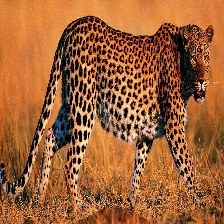

In [ ]:
img

### 2. Transform v2

numpy는 dataloader에서 자동으로 tensor 변환이 되나, pil은 자동으로 tensor변환이 되지 않습니다.

따라서 이런 경우 변환해주는 함수를 사용해야합니다. transform을 활용해서 이 작업을 해봅시다. 최근에는 v2버전이 추가되어 권장하고 있으므로 이를 통해서 해보겠습니다

https://pytorch.org/vision/0.17/transforms.html#v1-or-v2-which-one-should-i-use

In [ ]:
from torchvision.transforms import v2

transform = v2.Compose([
    v2.ToImage(),# ToTensor와 거의 동일하나, 이미지 데이터라는 구분을 할 수 있는 Image 클래스로 변환
    v2.ToDtype(torch.float32, scale=True) #
])

In [ ]:
valid_data2 = datasets.ImageFolder(path + '/valid', transform = transform)

In [ ]:
valid_data2[0][0]

Image([[[0.8784, 0.8431, 0.8745,  ..., 0.8549, 0.8902, 0.8588],
        [0.8431, 0.8353, 0.8549,  ..., 0.8784, 0.8510, 0.8471],
        [0.9216, 0.8784, 0.8431,  ..., 0.8275, 0.8471, 0.8431],
        ...,
        [0.7333, 0.8627, 0.6118,  ..., 0.4157, 0.4431, 0.5569],
        [0.7137, 0.6784, 0.9020,  ..., 0.4039, 0.4118, 0.5176],
        [0.7294, 0.7137, 0.4980,  ..., 0.3490, 0.3294, 0.4941]],

       [[0.5176, 0.4824, 0.5098,  ..., 0.4706, 0.4902, 0.4588],
        [0.4824, 0.4745, 0.4902,  ..., 0.4941, 0.4627, 0.4471],
        [0.5608, 0.5176, 0.4784,  ..., 0.4431, 0.4588, 0.4549],
        ...,
        [0.3765, 0.5373, 0.3412,  ..., 0.2275, 0.2431, 0.3412],
        [0.3804, 0.3765, 0.6588,  ..., 0.2275, 0.2078, 0.3059],
        [0.4039, 0.4157, 0.2627,  ..., 0.1765, 0.1333, 0.2824]],

       [[0.2314, 0.1961, 0.2353,  ..., 0.2157, 0.2314, 0.2000],
        [0.1961, 0.1882, 0.2157,  ..., 0.2392, 0.2000, 0.1882],
        [0.2745, 0.2314, 0.2039,  ..., 0.1882, 0.1961, 0.1922],
        ..

In [ ]:
type(valid_data2[0][0])

torchvision.tv_tensors._image.Image

tensor로 변환되면서 0~1 범위로 조정됩니다

In [ ]:
valid_data2[0][0].max()

tensor(1.)

In [ ]:
valid_data2[0][0].min()

tensor(0.)

matplotlib로 이미지 출력시에는 numpy로 변환하고, 컬러채널을 가장 뒤쪽으로 변경해줍니다. C,H,W --> H,W,C

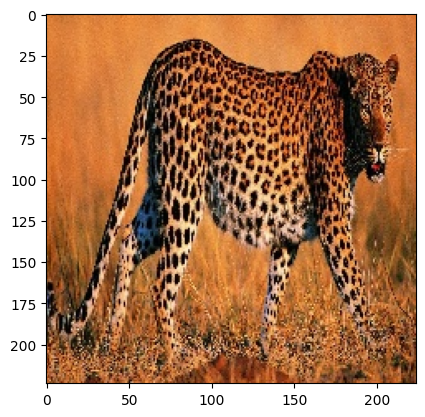

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(valid_data2[0][0].numpy().transpose(1,2,0))

In [ ]:
transform2 = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.4903, 0.4462, 0.3667], std=[0.2175, 0.2066, 0.2014])  # (R, G, B) 순서
])

In [ ]:
valid_data3 = datasets.ImageFolder(path + '/valid', transform = transform2)

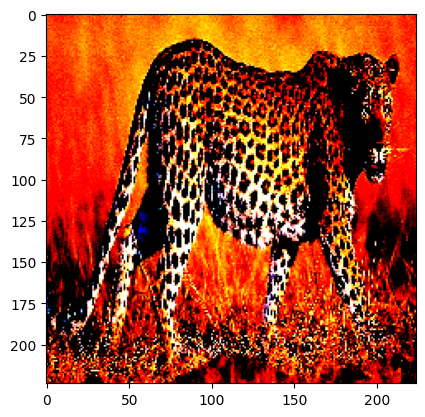

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(valid_data3[0][0].numpy().transpose(1,2,0))

다양한 변환이 있습니다. 이미지에 직접 적용할 수 있습니다.

randomcrop을 해보도록 하겠습니다.

In [ ]:
transform3 = v2.Compose([
    v2.RandomCrop(size=(200,200))

])

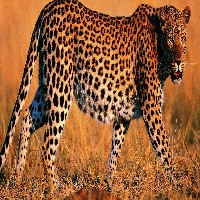

In [ ]:
transform3(valid_data[0][0])

### 3. 평균, 표준편차 계산

train dataset에서 평균, 표준편차를 계산해봅시다.


In [ ]:
train_data = datasets.ImageFolder(path + '/train', transform = transform)

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm # for loop 진행상황 확인

# DataLoader 설정
loader = DataLoader(train_data, batch_size=32, shuffle=False, num_workers = 4)

# 평균과 표준편차를 계산하기 위한 초기화
mean = torch.zeros(3)
std = torch.zeros(3)
total_images = 0

# 데이터셋을 배치 단위로 처리
for images, _ in tqdm(loader):
    batch_size = images.size(0)
    images = images.view(batch_size, images.size(1), -1)  #배치, 채널수, 이미지로 변환

    mean += images.mean(2).sum(0) # 이미지에 대해서 평균을 계산하고, 배치에 대해서 합을 구함
    std += images.std(2).sum(0)
    total_images += batch_size

# 최종 평균과 표준편차 계산
mean /= total_images
std /= total_images

# 결과 출력
print('Mean by channel:', mean)
print('Standard deviation by channel:', std)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 74/74 [03:27<00:00,  2.80s/it]

Mean by channel: tensor([0.4903, 0.4462, 0.3667])
Standard deviation by channel: tensor([0.2171, 0.2066, 0.2016])
